In [1]:
import os
import shutil
import random
import tensorflow as tf
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout,AveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, GaussianNoise, GlobalMaxPooling2D
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import (
    cohen_kappa_score, matthews_corrcoef, roc_auc_score, log_loss,
    precision_score, recall_score, f1_score, confusion_matrix
)
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Paths
dataset_dir = '/Users/sukanya/Documents/Alziemers Multi Modal/Dataset/MRI Images' 
train_dir = '/Users/sukanya/Documents/Alziemers Multi Modal/Split Dataset/train'  
test_dir = '/Users/sukanya/Documents/Alziemers Multi Modal/Split Dataset/test'    

## Splitting Data Into Train and Test

In [15]:
# train-test split 
split_ratio = 0.8 

# Train and test directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for class_folder in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_folder)
    
    if os.path.isdir(class_path):
        train_class_path = os.path.join(train_dir, class_folder)
        test_class_path = os.path.join(test_dir, class_folder)
        os.makedirs(train_class_path, exist_ok=True)
        os.makedirs(test_class_path, exist_ok=True)
        
        images = os.listdir(class_path)

        random.shuffle(images)
        split_point = int(len(images) * split_ratio)
        train_images = images[:split_point]
        test_images = images[split_point:]
        
        for image in train_images:
            shutil.copy(os.path.join(class_path, image), os.path.join(train_class_path, image))
        
        for image in test_images:
            shutil.copy(os.path.join(class_path, image), os.path.join(test_class_path, image))

print("Train-test split complete!")

Train-test split complete!


# Loading Images and Labels

In [3]:
#  Loading images and label
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(256, 256),  
    batch_size=32,         
    label_mode='int',       
    shuffle=True
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(256, 256),
    batch_size=32,
    label_mode='int',
    shuffle=True
)

Found 795 files belonging to 4 classes.
Found 201 files belonging to 4 classes.


In [4]:
# Class Names
class_names = train_dataset.class_names
print("Class names:", class_names)

Class names: ['Mild Dementia', 'Moderate Dementia', 'No Dementia', 'Severe Dementia ']


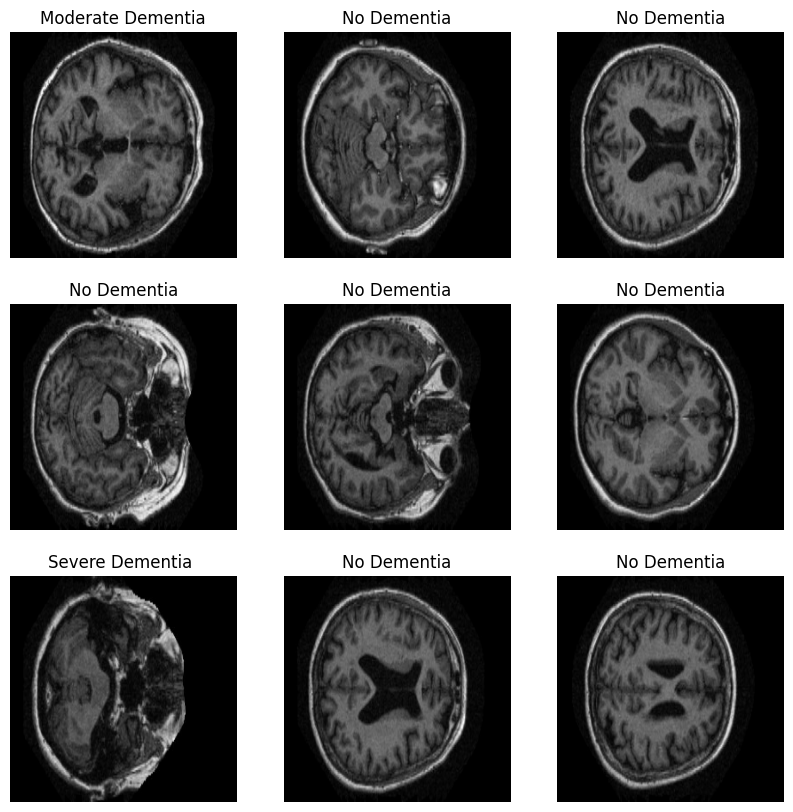

In [5]:
# Displaying Images
image_batch, label_batch = next(iter(train_dataset))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8")) 
    plt.title(class_names[label_batch[i]]) 
    plt.axis("off")  
plt.show()

## Normalizing Images


In [6]:
# Normalize the image data
normalization_layer = layers.Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

In [7]:
input_shape = (256, 256, 3)

# CNN Model 1

In [8]:
# CNN Model
model = Sequential()
model.add(Conv2D(32, (2, 2),activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(32, (2, 2),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (2, 2),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(4,activation='softmax'))

In [9]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 255, 255, 32)      416       
                                                                 
 batch_normalization (Batch  (None, 255, 255, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 127, 127, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 32)      4128      
                                                                 
 batch_normalization_1 (Bat  (None, 126, 126, 32)      1

In [10]:
# Training the model
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=15 
)

Epoch 1/15
25/25 [==============================] - 9s 325ms/step - loss: 3.5671 - accuracy: 0.6151 - val_loss: 31.5374 - val_accuracy: 0.0697
Epoch 2/15
25/25 [==============================] - 8s 308ms/step - loss: 0.6966 - accuracy: 0.7006 - val_loss: 63.3871 - val_accuracy: 0.0697
Epoch 3/15
25/25 [==============================] - 8s 306ms/step - loss: 0.6003 - accuracy: 0.7346 - val_loss: 82.9833 - val_accuracy: 0.0697
Epoch 4/15
25/25 [==============================] - 8s 301ms/step - loss: 0.5340 - accuracy: 0.7384 - val_loss: 92.0029 - val_accuracy: 0.0697
Epoch 5/15
25/25 [==============================] - 8s 303ms/step - loss: 0.4804 - accuracy: 0.7384 - val_loss: 97.5686 - val_accuracy: 0.0697
Epoch 6/15
25/25 [==============================] - 8s 303ms/step - loss: 0.4241 - accuracy: 0.7736 - val_loss: 99.8024 - val_accuracy: 0.0697
Epoch 7/15
25/25 [==============================] - 8s 304ms/step - loss: 0.4536 - accuracy: 0.7698 - val_loss: 99.6457 - val_accuracy: 0.0697

## Model Metrics

In [16]:
# Evaluation
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)
predictions = model.predict(test_dataset)
predicted_labels = np.argmax(predictions, axis=1)

accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy}")

print("Classification Report:\n")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

predicted_labels = np.argmax(predictions, axis=1)

# F1 Score
f1 = f1_score(true_labels, predicted_labels, average='weighted')
print(f"F1 Score: {f1}")

# Log Loss
logloss = log_loss(true_labels, predictions)
print(f"Log Loss: {logloss:.2f}")

# Cohen's Kappa Score
kappa = cohen_kappa_score(true_labels, predicted_labels)
print(f"Cohen's Kappa Score: {kappa:.2f}")

# Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(true_labels, predicted_labels)
print(f"Matthews Correlation Coefficient: {mcc:.2f}")

# Specificity, Sensitivity, FPR, and FNR
cm = confusion_matrix(true_labels, predicted_labels)
specificities, sensitivities, fprs, fnrs = [], [], [], []
for i in range(len(class_names)):
    tn = np.sum(cm) - (np.sum(cm[i, :]) + np.sum(cm[:, i]) - cm[i, i])  # True Negatives for class i
    fp = np.sum(cm[:, i]) - cm[i, i]  # False Positives for class i
    fn = np.sum(cm[i, :]) - cm[i, i]  # False Negatives for class i
    tp = cm[i, i]                     # True Positives for class i
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0

    specificities.append(specificity)
    sensitivities.append(sensitivity)
    fprs.append(fpr)
    fnrs.append(fnr)
    
print(f"Specificities: {specificities}")
print(f"Sensitivities (Recall): {sensitivities}")
print(f"False Positive Rates: {fprs}")
print(f"False Negative Rates: {fnrs}")

# G-Mean
g_mean = np.sqrt(np.mean(sensitivities) * np.mean(specificities))
print(f"G-Mean: {g_mean:.2f}")

# Fowlkes-Mallows Index (FMI)
fmi = np.sqrt(np.mean(precision_score(true_labels, predicted_labels, average=None)) * np.mean(recall_score(true_labels, predicted_labels, average=None)))
print(f"Fowlkes-Mallows Index: {fmi:.2f}")

7/7 [==============================] - 0s 62ms/step
Accuracy: 0.08955223880597014
Classification Report:

                   precision    recall  f1-score   support

    Mild Dementia       0.00      0.00      0.00        27
Moderate Dementia       0.07      0.86      0.12        14
      No Dementia       0.00      0.00      0.00        98
 Severe Dementia        0.26      0.10      0.14        62

         accuracy                           0.09       201
        macro avg       0.08      0.24      0.07       201
     weighted avg       0.09      0.09      0.05       201

F1 Score: 0.052253438688908395
Log Loss: 14.09
Cohen's Kappa Score: -0.01
Matthews Correlation Coefficient: -0.02
Specificities: [1.0, 0.11229946524064172, 1.0, 0.8776978417266187]
Sensitivities (Recall): [0.0, 0.8571428571428571, 0.0, 0.0967741935483871]
False Positive Rates: [0.0, 0.8877005347593583, 0.0, 0.1223021582733813]
False Negative Rates: [1.0, 0.14285714285714285, 1.0, 0.9032258064516129]
G-Mean: 0.42
Fow

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.11/site-packag

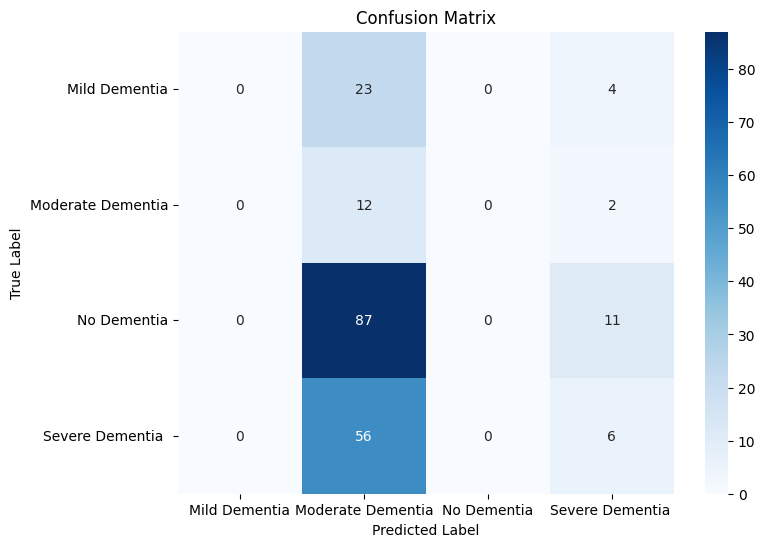

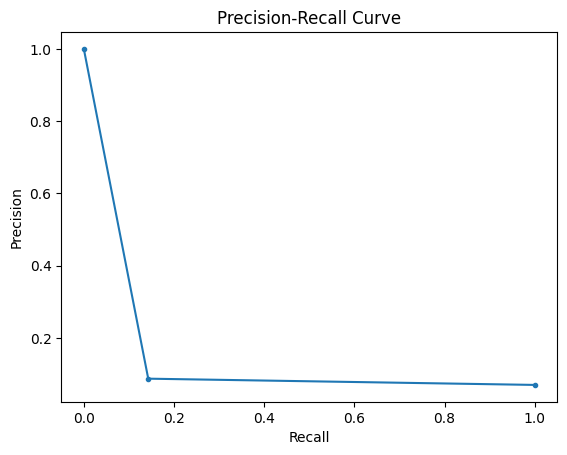

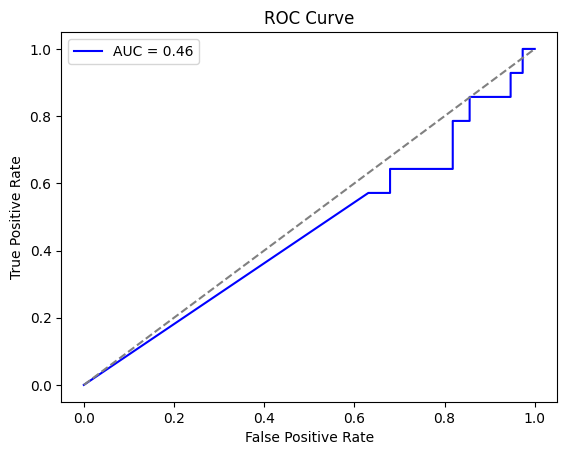

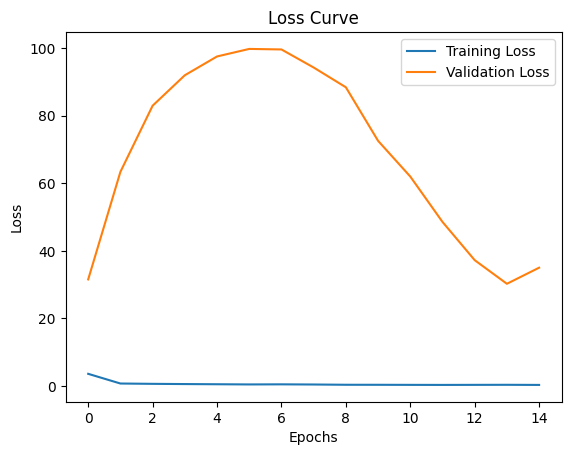

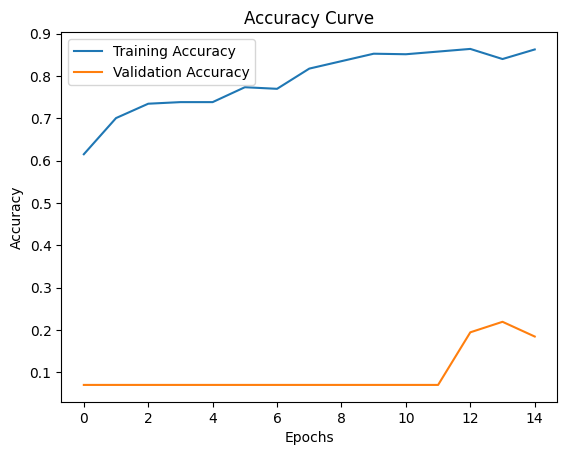

In [17]:
# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(true_labels, predicted_labels, pos_label=1)
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(true_labels, predictions[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Loss Curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#  Accuracy Curve
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
